In [1]:
pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   - -------------------------------------- 1.8/39.0 MB 12.6 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/39.0 MB 16.0 MB/s eta 0:00:03
   ----------- ---------------------------- 10.7/39.0 MB 19.2 MB/s eta 0:00:02
   --------------- ------------------------ 15.5/39.0 MB 19.8 MB/s eta 0:00:02
   --------------------- ------------------ 21.0/39.0 MB 21.4 MB/s eta 0:00:01
   ------------------------- -------------- 24.9/39.0 MB 21.0 MB/s eta 0:00:01
   ------------------------------- -------- 30.9/39.0 MB 22.0 MB/s eta 0:00:01
   ------------------------------------- -- 36.7/39.0 MB 22.9 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 21.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

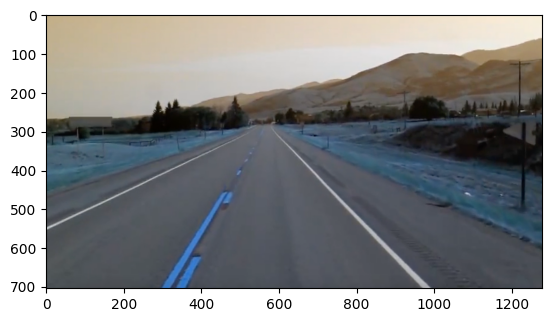

In [74]:
image_path = r"C:\Users\dyuti\OneDrive\Desktop\test_image.jpg"
image = cv2.imread(image_path) #converts the image into multidimensional numpy array
cv2.imshow('result', image)
cv2.waitKey(0)
plt.imshow(image)

In [75]:
 #Grayscale
lane_image = np.copy(image)
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
cv2.imshow('result', gray)
cv2.waitKey(0)

-1

In [76]:
#Gaussian blur
blur = cv2.GaussianBlur(gray, (5,5), 0)
cv2.imshow('result', blur)
cv2.waitKey(0)


-1

In [77]:
#applying canny edge function
c = cv2.Canny(blur, 50,150)
cv2.imshow('result', c)
cv2.waitKey(0)

-1

In [78]:
lane_image = np.copy(image)

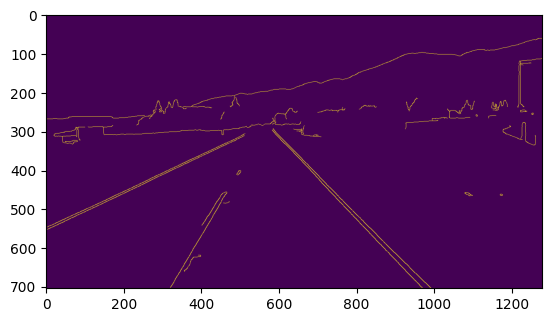

In [79]:
#canny function will contain all the changes
def canny(image):
    gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY) #original image
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50,150)
    return canny

plt.imshow(canny(lane_image))


    
    

Thus we got the image that is grayscaled, gaussiun blurred and applied on with canny algorithm. 


In [80]:
#array of image applied with canny edge function 
c1 = canny(lane_image) 

In [81]:
#region of interest
def region_of_int(image):
    height = image.shape[0] 
    #Coordinates of the triangular region
    polygons = np.array([
        [(200,height), (1100, height), (550, 250)]
    ])
    #Create a black image with the same dimensions as original image
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)#filling the traced polygon with white
    return mask
    
cv2.imshow("result", region_of_int(c1))
cv2.waitKey(0)
    
    

-1

In [82]:
#Bitwise on the canny edge image
def region_of_int(image):
    height = image.shape[0]
    #Coordinates of the triangular region
    polygons = np.array([
        [(200,height), (1100, height), (550, 250)]
    ])
    #create a black image with the same dimensions as original image  
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image



In [83]:
cropped_image = region_of_int(c1)
cv2.imshow("result", cropped_image)
cv2.waitKey(0)

-1

In [84]:
#Hough transform  
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength = 40, maxLineGap = 5)

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    
    #to make sure array is not empty
    if lines is not None: 
       for line in lines:
            x1, y1, x2, y2= line.reshape(4)
            
            #Black lines on image
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image 
    
    



In [85]:
line_image = display_lines(lane_image, lines)
cv2.imshow("result", line_image)
cv2.waitKey(0)

-1

In [86]:
#sum of color image(lane_image) with weights, i.e merging the black and original image
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
cv2.imshow("result", combo_image)
cv2.waitKey(0)

-1

In [87]:
#optimization 

#the coordinates for the averaged out single line
def make_coord(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])
  


#average the slope of multiple lines and make one line
def average_slope(image, lines):
    left_fit= []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2= line.reshape(4)
        
        #fit line to points, return slope and y-int
        parameters = np.polyfit((x1, x2), (y1, y2), 1) 
        slope = parameters[0]
        intercept = parameters[1]
        #lines on the right have positive slope, and lines on the left have negative slope
        if slope < 0:
            left_fit.append((slope, intercept))
        else: 
            right_fit.append((slope, intercept))
    
    #average of all the columns (column0: slope, cloumns: y_int)
    left_fit_avg = np.average(left_fit, axis = 0)
    right_fit_avg = np.average(right_fit, axis = 0)
    
    #Create line based on avg value
    left_line = make_coord(image, left_fit_avg)
    right_line = make_coord(image, right_fit_avg)
    return np.array([left_line, right_line])
            

In [88]:
def average_slope(image, lines):
    left_fit = []
    right_fit = []

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2), (y1,y2), 1)  # returns [slope, intercept]
        slope = parameters[0]
        if slope < 0:
            left_fit.append(parameters)
        else:
            right_fit.append(parameters)

    left_fit_avg = np.mean(left_fit, axis=0) if left_fit else None
    right_fit_avg = np.mean(right_fit, axis=0) if right_fit else None

    lines_to_draw = []
    if left_fit_avg is not None:
        lines_to_draw.append(make_coord(image, left_fit_avg))
    if right_fit_avg is not None:
        lines_to_draw.append(make_coord(image, right_fit_avg))

    return np.array(lines_to_draw)

def make_coord(image, line_parameters):
    slope, intercept = line_parameters  # now guaranteed to be iterable
    y1 = image.shape[0]
    y2 = int(y1 * 3/5)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])
'''averaged_lines = average_slope(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
cv2.imshow("result", line_image)
cv2.waitKey(0)'''

'averaged_lines = average_slope(lane_image, lines)\nline_image = display_lines(lane_image, averaged_lines)\ncv2.imshow("result", line_image)\ncv2.waitKey(0)'

In [89]:
averaged_lines = average_slope(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
cv2.imshow("result", line_image)
cv2.waitKey(0)

-1